In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pk
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
data_file_1_name = 'data/AlarmLogExport-20180622-145808.CSV'
data_file_2_name = 'data/AlarmLogExport-20180622-145852.CSV'

# alarm ID 不能够以浮点数的形式读入，显式指明为字符串
data_type = str

In [4]:
data1 = pd.read_csv(
    data_file_1_name,
    header=0,
    dtype=data_type
    )
# data1.describe()
data1.head()
# data1.shape

,告警ID,告警级别,告警名称,告警对象,对象类型,产生时间,清除时间,清除类型
0,15.1008005,次要,主机管理域CPU占用率超过阈值,MCNA02,主机,2018-06-22 14:55:00 UTC+08:00,-,-
1,15.1000101,重要,虚拟机CPU占用率超过阈值,VW07-132-98-0-54,虚拟机,2018-06-22 14:55:00 UTC+08:00,-,-
2,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-54,虚拟机,2018-06-22 06:17:00 UTC+08:00,-,-
3,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-111,虚拟机,2018-06-22 04:46:00 UTC+08:00,-,-
4,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-20 17:32:00 UTC+08:00,-,-


## 1. 准备训练数据
1. 为每一种告警，生成一个唯一的索引index，并且使用一个类`AlarmSummary`（类似于以前看到了那一个Lang类一样），该类维护这些数据
    1. index2id -> dict：使用唯一的索引index得到对应的alarm_id
    2. id2index -> dict：使用告警的id，得到对应的唯一的索引index
    3. alarm_num -> int: 记录目前告警的数量
    4. id2full -> dict : 得到告警的详细信息
2. 将告警日志按照时间进行排序，并进行适当的简化
    1. 只有一列， 按照时间先后顺序排序的事件id list

### 1.1 AlarmSummary类

In [5]:
class AlarmSummary():
    def __init__(self, name):
        self.name = name
        self.index2id = {}
        self.id2index = {}
        self.id2full = {}
        self.alarm_num = 0
    def addAlarm(self, alarm_id, alarm_level, alarm_content):
        '''
        add a new alarm type
        '''
        if alarm_id not in self.id2full.keys():
            self.id2full[alarm_id] = {
                'level':alarm_level,
                'content':alarm_content
            }
            new_index = self.alarm_num
            self.index2id[new_index] = alarm_id
            self.id2index[alarm_id] = new_index
            
            self.alarm_num += 1
    def get_index(self, alarm_id):
        return self.id2index[alarm_id]

In [6]:
bare_id = data1.iloc[:,0:3]
alarm_id_column_name = bare_id.columns[0]
# 获取第一列的索引值，并以此列进行去重,去重后按照id排序
bare_ids = bare_id.drop_duplicates(alarm_id_column_name, keep='last').sort_values(by=alarm_id_column_name)

this_alarm_summary = AlarmSummary(data_file_1_name)

# 将目前的数据集中的告警信息加入到类中
for index, row in bare_ids.iterrows():
    this_alarm_summary.addAlarm(row[0], row[1], row[2])

print(this_alarm_summary.index2id, this_alarm_summary.id2index, this_alarm_summary.id2full)

# 结果：this_alarm_summary

{0: '15.1000020', 1: '15.1000032', 2: '15.1000036', 3: '15.1000101', 4: '15.1000102', 5: '15.1000103', 6: '15.1002006', 7: '15.1004005', 8: '15.1004014', 9: '15.1005003', 10: '15.1005007', 11: '15.1006000', 12: '15.1006001', 13: '15.1006008', 14: '15.1008002', 15: '15.1008005', 16: '15.1008007'} {'15.1006001': 12, '15.1008005': 15, '15.1005003': 9, '15.1000036': 2, '15.1000032': 1, '15.1004014': 8, '15.1008007': 16, '15.1000020': 0, '15.1000102': 4, '15.1008002': 14, '15.1000103': 5, '15.1000101': 3, '15.1004005': 7, '15.1006000': 11, '15.1002006': 6, '15.1005007': 10, '15.1006008': 13} {'15.1006001': {'level': '重要', 'content': '网口自协商速率没有达到服务器网口的最大速率'}, '15.1008005': {'level': '次要', 'content': '主机管理域CPU占用率超过阈值'}, '15.1005003': {'level': '重要', 'content': '存储使用容量超过阈值'}, '15.1000036': {'level': '次要', 'content': '主机逻辑磁盘占用率超过阈值'}, '15.1000032': {'level': '次要', 'content': '主机CPU占用率超过阈值'}, '15.1004014': {'level': '重要', 'content': 'Libvirt管理端口认证未开启'}, '15.1008007': {'level': '次要', 'content': '

### 1.2 准备数据
最终得到一个由事件id组成的序列

In [27]:
time_column_name = data1.columns[5]
# time_column_name
# 得到排序后的一列
alarm_id_list = list(data1.sort_values(by=time_column_name)[alarm_id_column_name])
alarm_id_list[:10]

['15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000102',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103']

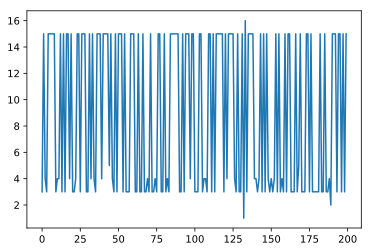

In [8]:
alarm_index_list = [this_alarm_summary.get_index(i) for i in alarm_id_list]
alarm_index_list
with open('data/alarm_index_list.pk', 'wb') as f:
    pk.dump(alarm_index_list, f)
plt.plot(alarm_index_list[1000:1200])

## 2 进一步处理数据

在这些方面，我需要对数据进行进一步处理：
1. 在不同的维度，对数据进行分类
    1. 对于告警，有的告警是针对主机的，而有的告警是针对虚拟机的，同时，即使是同一类的告警，也可能是发生在不同的主机上，或者不同的虚拟机上，需要区分。

In [25]:
data1[ ( data1['对象类型'] == '虚拟机' ) & ( data1['告警对象'] == 'VW07-132-98-0-52' ) ][:20]

,告警ID,告警级别,告警名称,告警对象,对象类型,产生时间,清除时间,清除类型
4,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-20 17:32:00 UTC+08:00,-,-
1434,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-13 11:08:00 UTC+08:00,2018-06-18 13:12:00 UTC+08:00,正常清除
1696,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-12 10:17:00 UTC+08:00,2018-06-12 15:06:00 UTC+08:00,正常清除
2694,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-08 09:53:00 UTC+08:00,2018-06-12 06:19:00 UTC+08:00,正常清除
3181,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-05 06:16:00 UTC+08:00,2018-06-07 18:37:00 UTC+08:00,正常清除
3726,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-01 08:32:00 UTC+08:00,2018-06-02 02:55:00 UTC+08:00,正常清除
4184,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-30 10:29:00 UTC+08:00,2018-06-01 06:08:00 UTC+08:00,正常清除
4904,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-25 15:37:00 UTC+08:00,2018-05-29 09:30:00 UTC+08:00,正常清除
4912,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-25 14:42:00 UTC+08:00,2018-05-25 14:49:00 UTC+08:00,正常清除
5345,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-21 10:07:00 UTC+08:00,2018-05-25 14:34:00 UTC+08:00,正常清除


In [49]:
# 告警对象筛选器
alarm_object = data1[~data1.duplicated('告警对象')]
alarm_object[alarm_object['对象类型']=='主机']

,告警ID,告警级别,告警名称,告警对象,对象类型,产生时间,清除时间,清除类型
0,15.1008005,次要,主机管理域CPU占用率超过阈值,MCNA02,主机,2018-06-22 14:55:00 UTC+08:00,-,-
14,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna06,主机,2018-06-15 15:05:00 UTC+08:00,-,-
15,15.1006008,提示,主机管理接口未配置网络冗余,MCNA01,主机,2018-06-15 15:05:00 UTC+08:00,-,-
16,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna05,主机,2018-06-15 15:05:00 UTC+08:00,-,-
17,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna04,主机,2018-06-15 15:05:00 UTC+08:00,-,-
18,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna03,主机,2018-06-15 15:05:00 UTC+08:00,-,-
19,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna02,主机,2018-06-15 15:05:00 UTC+08:00,-,-
20,15.1006008,提示,主机管理接口未配置网络冗余,desktop_cna01,主机,2018-06-15 15:05:00 UTC+08:00,-,-
25,15.1000020,重要,内存预留率超过阈值,D-3-6-1-4_192.168.130.132,主机,2018-06-13 16:24:00 UTC+08:00,-,-
30,15.1000020,重要,内存预留率超过阈值,D-3-6-1-6_192.168.130.170,主机,2018-06-12 03:30:00 UTC+08:00,-,-


(6017, 8)

In [32]:
data1['对象类型'] == '虚拟机'

0       False
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22       True
23       True
24       True
25      False
26      False
27      False
28       True
29       True
        ...  
5987     True
5988     True
5989     True
5990     True
5991     True
5992     True
5993     True
5994     True
5995     True
5996     True
5997     True
5998     True
5999     True
6000     True
6001     True
6002     True
6003     True
6004     True
6005     True
6006     True
6007     True
6008     True
6009     True
6010     True
6011     True
6012     True
6013     True
6014     True
6015     True
6016     True
Name: 对象类型, Length: 6017, dtype: bool